In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
cd "/gdrive/MyDrive/Apuntes papers "


/gdrive/MyDrive/Apuntes papers 


In [ ]:
!pip install powerlaw

  Created wheel for powerlaw: filename=powerlaw-1.4.6-py3-none-any.whl size=24786 sha256=eecebf7dd9ae09d7f33bcb57c3e8a550d301ab91549caefaa6ee85f4a5dd1c37
  Stored in directory: /root/.cache/pip/wheels/ee/51/38/2e0f20cf80e1a0909acdd527df2288bd9feb8356b926d7d775
Successfully built powerlaw


In [ ]:
#networkx para teoría de grafos, matplot para gráficar, random para generar números aleatorios, stats para la entropia y solve para optimizar.
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp 
from scipy import stats as st
import math 
from scipy.optimize import fsolve
import powerlaw

In [ ]:
#Este algoritmo es para muestrar secuencias de enteros on una distribución dada. (Montecarlo
def Degree_Sec_Generator(Probabilidad_Acumulada,longitud_Secuencia,m):
  """
  (Vector Probabilidada Acumulada, Longitud Secuencia,m) -------> (Secuencia de enteros con la distribución del vector)
  Este algoritmo es para muestrar secuencias de enteros on una distribución dada. (Montecarlo)
  recuerde que si quiere una secuencia de grado longitud_Secuencia = len(Probabilidad_Acumulada)
  m corresponde al valor mínimo desde el cual se muestreará la distribución, si no es necesario poner 0.
  """
  Degree_Sequence = []
  sum = 0
  intentos = 100000
  for i in range(intentos):
    k = np.random.rand()*Probabilidad_Acumulada[len(Probabilidad_Acumulada)-1]
    #k = st.uniform.rvs(scale = Probabilidad_Acumulada[len(Probabilidad_Acumulada)-1]) #Se generan números aleatoriamente entre 0 y 0.9999
    for j in range(len(Probabilidad_Acumulada)): 
      if k <= Probabilidad_Acumulada[j]: # Asocia un entero positivo a cada número entre 0-0.9999
        if j <= round(len(Probabilidad_Acumulada)**(1/2) + 10):
          Degree_Sequence.append(j+m-1) #construye el vector con los enteros positivos asociados a los números entre 0-1
          break
    if len(Degree_Sequence) == longitud_Secuencia:
      break
  return Degree_Sequence
  
def Degre_sec_extractor(G):
  degree_secuence = []
  deg = nx.degree(G)
  for i in range(len(deg)):
    degree_secuence.append(deg(i))
  return degree_secuence

In [ ]:
#esta función recibe vector de probabilidades acumulada y un entero, te entrega un grafo generado con el algoritmo expuesto
#en el proyecto que sustenta este respositorio
def maxent_generator(cum_probability,number_nodes,m):
  """
  (cum_probability,number_nodes) -----> G
  esta función recibe vector de probabilidades acumulada y un entero, te entrega un grafo generado con el algoritmo expuesto
  en el proyecto que sustenta este respositorio
  """
  for k in range(1000000000000):
          Degree_Sequence = Degree_Sec_Generator(cum_probability,number_nodes,m) #se genera secuencia
          if nx.is_valid_degree_sequence_havel_hakimi(Degree_Sequence) == True:
            if nx.is_connected(nx.havel_hakimi_graph(Degree_Sequence)) == True: #se comprueba si permite crear un grafo simple conectado
              Degree_Sequence.sort() #ordenamos la secuencia
              Grafo = nx.havel_hakimi_graph(Degree_Sequence) #creamos el grafo con el algoritmo havel hakimi
              break
  nx.double_edge_swap(Grafo,nswap=1000,max_tries=1500000) #Se aleatoriza el grafo manteniendo su secuencia de grado constante
  return Grafo

In [ ]:
#Estas funciones remueven N nodos o enlaces del grafo ingresado
def remove_hubs_load(G,nodos_removidos): #remueve nodos con mayor load
  """
  (G, #nodos_removidos) ---------> G
  """
  for i in range(nodos_removidos):
    keys = list(nx.load_centrality(G).keys())
    values = list(nx.load_centrality(G).values())
    maxval = max(values)
    casilla_nodo = values.index(maxval)
    G.remove_node(keys[casilla_nodo])
  return G
 
def edge_remove_hub_load(G,edges_removidos): #remueve edges con mayor load
  """
  (G,#edges_removidos) -------> G
  """
  for i in range(edges_removidos):
    keys = list(nx.edge_load_centrality(G).keys())
    values = list(nx.load_centrality(G).values())
    maxval = max(values)
    casilla_edge = values.index(maxval)
    G.remove_edge(keys[casilla_edge][0],keys[casilla_edge][1])
  return G
 
 
def remove_aleatory(G,nodos_removidos): #remueve nodos aleatoriamente
  """
  (G,#nodos_removidos) -----------> G
  """
  keys = list(G.nodes())
  for i in range(nodos_removidos):
    remove_node = np.random.randint(0,G.number_of_nodes())
    remnode = keys[remove_node]
    if (remnode in G) == True:
      G.remove_node(remnode)
  return G
 
def edge_remove_aleatory(G,edges_removidos): #remueve edges aleatoriamente
  """
  (G,#edges_removidos) ------> G
  """
  for i in range(edges_removidos):
    remove_edge = np.random.randint(0,len(nx.edges(G)))
    if (remove_edge in G) ==True:
      G.remove_edge(list(nx.edges(G))[remove_edge][0],list(nx.edges(G))[remove_edge][1])
  return G

In [ ]:
#Estas dos funciones atacan nodos y enlaces en base al ranking en la medida fload y causan una falla en cascada
# la falla en cascada se realiza recalculando el load en la red y eliminando con cierta probabilidad los nodos que tengan un load mayor 
# a su loadinicial*resiliencia, si el load supera un valor dado la probabilidad de eliminación es 100%
 
def hub_cascade_failure(G,Initial_Capacity,Resiliencia,Number_Attacks):
  """
  (Graph,float,float,int) -------> (G)
  Esta función ataca nodos acorde a su ranking en la medida load y luego aplica una falla en cascada
  acorde a que nodos soportan un mayor load que el dado por su capacidad inicial y resiliencia
  """
  load1 = nx.load_centrality(G)
  keys1 = list(load1.keys())
  values1 = list(load1.values())
  nodes = len(G.nodes())
  Capacity = []
  for i in range(len(keys1)): #se definen condiciones iniciales
    q = (1+Initial_Capacity)*load1[keys1[i]]
    Capacity.append(q)
  DAMAGE = []
  ATTACK = []
  for i in range(Number_Attacks): #en este for se ejecutan los ataques
    NodosBC = len(max(nx.connected_components(G), key=len))
    DAMAGE.append(NodosBC/nodes) #registramos el daño con el cambio en el tamaño de la componente principal
    ATTACK.append(i) #registramos el número de ataque
    remove_hubs_load(G,1) #se remueve el nodo con mayor load
    DELETE_NODES = []
    load = nx.load_centrality(G)
    for j in G.nodes():
      val = Resiliencia*Capacity[keys1.index(j)] #calculamos el valor de load sobre el cual un nodo colapsara con 100% de seguridad
      if load[j] > val: 
        DELETE_NODES.append(j) #enlistamos los nodos que colapsaran
      else:
        if load[j] > Capacity[keys1.index(j)]:#se elige si un nodo que ha superado su capacidad colapsa
          k = st.uniform.rvs()
          P = (1/(Resiliencia-1))*(load[j]/Capacity[keys1.index(j)] -1)
          if k <= P:
            DELETE_NODES.append(j) #enlistamos los nodos colapsados
    G.remove_nodes_from(DELETE_NODES) #se eliminan los nodos colapsados
 
  return G,ATTACK,DAMAGE
 
def edge_hub_cascade_failure(G,Initial_Capacity,Resiliencia,Number_Attacks):
  """
  (Graph,float,float,int) -------> (G)
  Esta función ataca nodos acorde a su ranking en la medida load y luego aplica una falla en cascada
  acorde a que nodos soportan un mayor load que el dado por su capacidad inicial y resiliencia
  """
  load1 = nx.edge_load_centrality(G)
  keys1 = list(load1.keys())
  values1 = list(load1.values())
  Capacity = []
  for i in range(len(keys1)): #se definen condiciones iniciales
    q = (1+Initial_Capacity)*load1[keys1[i]]
    Capacity.append(q)
  DAMAGEEDGE = []
  ATTACK = []
  for i in range(Number_Attacks): #en este for se ejecutan los ataques
    NodosBC = len(max(nx.connected_components(G), key = len))
    DAMAGEEDGE.append(NodosBC/len(G.nodes()))#registramos el daño con el cambio en el tamaño de la componente principal
    ATTACK.append(i) #registramos el número de ataque
    edge_remove_hub_load(G,1) #se remueve el edge con mas load 
    DELETE_EDGES = []
    load = nx.edge_load_centrality(G)
    for j in G.edges():
      val = Resiliencia*Capacity[keys1.index(j)] #calculamos el valor de load sobre el cual un nodo colapsara con 100% de seguridad
      if load[j] > val:  #enlistamos los nodos que colapsaran
        DELETE_EDGES.append(j)
      else:
        if load[j] > Capacity[keys1.index(j)]: #se elige si un nodo que ha superado su capacidad colapsa
          k = st.uniform.rvs()
          P = (1/(Resiliencia -1))*(load[j]/Capacity[keys1.index(j)] - 1)
          if k <= P:
            DELETE_EDGES.append(j) #enlistamos los nodos colapsados
    G.remove_edges_from(DELETE_EDGES) #se eliminan los nodos colapsados
    
  return G, ATTACK, DAMAGEEDGE

In [ ]:
def aleatory_cascade_failure(G,Initial_Capacity,Resiliencia,Number_Attacks):
  """
  (Graph,float,float,int) -------> (G,Vector con los daños, vector con el número de ataques)
  Esta función luego de atacar un nodo aleatoriamente ejecuta el algoritmo de falla en cascada y te entrega como resultado
  el grafo atacado, un vector con los daños por ataque y un vector con el número de ataques
  """
  load1 = nx.load_centrality(G)
  keys1 = list(load1.keys())
  values1 = list(load1.values())
  nodes = len(G.nodes())
  Capacity = []
  for i in range(len(keys1)): #se definen condiciones iniciales
    q = (1+Initial_Capacity)*load1[keys1[i]]
    Capacity.append(q)
  DAMAGE = []
  ATTACK = []
  for i in range(Number_Attacks): #en este for se ejecutan los ataques
    NodosBC = len(max(nx.connected_components(G), key = len))
    DAMAGE.append(NodosBC/len(G.nodes()))#registramos el daño con el cambio en el tamaño de la componente principal
    ATTACK.append(i) #registramos el número de ataque
    remove_aleatory(G,1) #se remueve un nodo aleatoriamente
    DELETE_NODES = []
    load = nx.load_centrality(G)
    for j in G.nodes():
      val = Resiliencia*Capacity[keys1.index(j)] #calculamos el valor de load sobre el cual el nodo colapsara con 100% de probabilidad
      if load[j] > val: 
        DELETE_NODES.append(j) #enlistamos los nodos colapsados
      else:
        if load[j] > Capacity[keys1.index(j)]: # se decide si un nodo que ha superado su capacidad colapsa
          k = st.uniform.rvs()
          P = (1/(Resiliencia-1))*(load[j]/Capacity[keys1.index(j)] -1)
          if k <= P:
            DELETE_NODES.append(j) #enlistamos los nodos colapsados
    G.remove_nodes_from(DELETE_NODES) #se eliminan los nodos colapsados
 
  return G,ATTACK,DAMAGE
 
def edge_aleatory_cascade_failure(G,Initial_Capacity,Resiliencia,Number_attacks):
  """
  (Graph,float,float,int) -------> (G,Vector con los daños, vector con el número de ataques)
  Esta función luego de atacar un enlace aleatoriamente ejecuta el algoritmo de falla en cascada y te entrega como resultado
  el grafo atacado, un vector con los daños por ataque y un vector con el número de ataques
  """
  load1 = nx.edge_load_centrality(G)
  keys1 = list(load1.keys())
  values1 = list(load1.values())
  Capacity = []
  nodes = len(G.nodes())
  for i in range(len(keys1)): #se definen condiciones iniciales
    q = (1+Initial_Capacity)*load1[keys1[i]]
    Capacity.append(q)
  DAMAGEEDGE = []
  ATTACK = []
  for i in range(Number_attacks): #en este for se ejecutan los ataques
    NodosBC = len(max(nx.connected_components(G), key = len))
    DAMAGEEDGE.append(NodosBC/len(G.nodes()))#registramos el daño con el cambio en el tamaño de la componente principal
    ATTACK.append(i) #registramos el número de ataque
    edge_remove_aleatory(G,1) #se remueve un edge aleatoriamente
    DELETE_EDGES = []
    load = nx.edge_load_centrality(G)
    for j in G.edges():
      val = Resiliencia*Capacity[keys1.index(j)] #calcula el valor de load sobre el cual un nodo colapsara con 100% de probabilidad
      if load[j] > val: 
        DELETE_EDGES.append(j) #enlistamos nodos colapsados
      else:
        if load[j] > Capacity[keys1.index(j)]: #se elige si un nodo que ha superado su capacidad colapsa
          k = st.uniform.rvs()
          P = (1/(Resiliencia -1))*(load[j]/Capacity[keys1.index(j)] - 1)
          if k <= P:
            DELETE_EDGES.append(j)
    G.remove_edges_from(DELETE_EDGES) #enlistamos nodos colapsados
 
  return G, ATTACK, DAMAGEEDGE

In [ ]:
# Está función calcula la entropía de distintas distribuciones de medidas para un grafo
def graph_entropys(G):
  """
  Recibe un grafo y entrega números
  (Graph) -----> Degree_Entropy, Eigenvector_Entropy, Betweenness_Entropy, Closeness_Entropy
  """
  EIGENVECTOR = []
  DEGREE = []
  BETWEENNESS = []
  CLOSENESS = []
  LOAD = []
  #las siguientes 4 lineas producen 4 diccionarios con los nodos y sus centralidades correspondientes
  eigenvector = nx.eigenvector_centrality(G,max_iter = 10000)
  degree = nx.degree(G) 
  betweenness = nx.betweenness_centrality(G) 
  closeness = nx.closeness_centrality(G) 
  load = nx.load_centrality(G)
  for i in range(len(eigenvector)): #este for desempaqueta los diccionarios, para coger solo las centralidades en listas
    EIGENVECTOR.append(eigenvector[i])
    DEGREE.append(degree[i])
    BETWEENNESS.append(betweenness[i])
    CLOSENESS.append(closeness[i])
    LOAD.append(load[i])
  # aca se usa el modulo stats de scipy para calcular las entropias
  Closeness_Entropy = st.entropy(CLOSENESS)
  Degree_Entropy = st.entropy(DEGREE)
  Eigenvector_Entropy = st.entropy(EIGENVECTOR)
  Betweenness_Entropy = st.entropy(BETWEENNESS)
  Load_Entropy = st.entropy(LOAD)
  return Degree_Entropy, Eigenvector_Entropy, Betweenness_Entropy, Closeness_Entropy, Load_Entropy

In [ ]:
#Esta función recibe un xfinal hasta donde sumar y un número de particiones.
#Juntos definen la longitud y el valor máximo del vector resultante
def pareto_cumm_probabilities(particiones,xfin, distribution = st.pareto.cdf):
  """
  (particiones,xfin) -----> (probability_cum_vector)
  Esta función recibe un xfinal hasta donde sumar y un número de particiones.
  Juntos definen la longitud y el valor máximo del vector resultante
  """
  dx = xfin/particiones
  x = []
  probability_cum_vector = []
  for i in range(particiones):
    equis = 1 + dx*i
    x.append(equis)
    pes = st.pareto.cdf(x[i],2.4) #se eligió un coeficiente de 2.4 para la distribución de pareto
    probability_cum_vector.append(pes)
  return probability_cum_vector, x # entrega como resultado el vector y los valores de x asociados
 
#Nnodes es el número de nodos
xfin = 5.9
Nnodes = 100
max_degree = Nnodes-1
P, x = pareto_cumm_probabilities(max_degree,xfin) #creamos el vector de probabilidades acumuladas
print(P)

[0.0, 0.1297113986410653, 0.23681637747088258, 0.32616368522356454, 0.4013853535864016, 0.46524240599449485, 0.5198618418858715, 0.5669021213080481, 0.6076706734855872, 0.6432086200544576, 0.6743527175222728, 0.7017812273687316, 0.7260482867071414, 0.7476099443199842, 0.7668440832191896, 0.7840658089235819, 0.7995394398212912, 0.8134879265510604, 0.8261003084925805, 0.83753765892932, 0.8479378573062638, 0.857419444410954, 0.8660847554481863, 0.8740224807416574, 0.8813097698908035, 0.8880139695997588, 0.8941940659051654, 0.8999018865929804, 0.9051831080709604, 0.9100781020166605, 0.9146226501323684, 0.9188485498481969, 0.9227841294776346, 0.926454687885914, 0.9298828709829733, 0.9330889951486152, 0.9360913259216977, 0.938906318848252, 0.9415488282157126, 0.9440322884476581, 0.9463688721529863, 0.948569628181713, 0.9506446025100114, 0.952602944338565, 0.9544529994239155, 0.9562023923587344, 0.9578580992629334, 0.9594265121344762, 0.9609134959295268, 0.9623244392903715, 0.9636642997116486

In [ ]:
Nnodes = 150
m = 3 #grado mínimo para las redes libres de escala
xfin = 50


GW = nx.watts_strogatz_graph(Nnodes,6,0.1)
GB = nx.barabasi_albert_graph(Nnodes,m)
secuence = Degre_sec_extractor(GB)
results = powerlaw.Fit(secuence,discrete = True)
alpha = results.power_law.alpha
xmin = results.power_law.xmin
print(alpha,"alpha barabasi")
max_degree = Nnodes -1
P, x = pareto_cumm_probabilities(max_degree,xfin,alpha-1) #creamos el vector de probabilidades acumuladas
GA = maxent_generator(P,Nnodes,m)
secuence2 = Degre_sec_extractor(GA)
results2 = powerlaw.Fit(secuence2, discrete = True)
alpha2 = results2.power_law.alpha
xmin2 = results2.power_law.xmin
print(alpha,alpha2,"exponentes")
print(xmin,xmin2,"xmin")
print(GW.number_of_edges(),GB.number_of_edges(),GA.number_of_edges(),"Número de enlaces")
 
wDegree_Entropy, wEigenvector_Entropy, wBetweenness_Entropy, wCloseness_Entropy, wLoad_entropy = graph_entropys(GW)
BDegree_Entropy, BEigenvector_Entropy, BBetweenness_Entropy, BCloseness_Entropy, BLoad_entropy = graph_entropys(GB)
ADegree_Entropy, AEigenvector_Entropy, ABetweenness_Entropy, ACloseness_Entropy, ALoad_entropy = graph_entropys(GA)
print(P[len(P)-1])
print(wDegree_Entropy,BDegree_Entropy,ADegree_Entropy,"degree")
print(wEigenvector_Entropy,BEigenvector_Entropy, AEigenvector_Entropy,"eigen")
print(wBetweenness_Entropy,BBetweenness_Entropy, ABetweenness_Entropy,"betweenness")
print(wCloseness_Entropy,BCloseness_Entropy, ACloseness_Entropy,"closeness")
print(wLoad_entropy,BLoad_entropy, ALoad_entropy,"load")

Calculating best minimal value for power law fit
/usr/local/lib/python3.7/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit


2.5411777435234626 alpha barabasi
2.5411777435234626 3.4034341235370595 exponentes
3.0 4.0 xmin
450 441 338 Número de enlaces
0.9999189575758338
5.0022730356420375 4.7361023583260105 4.9076503058898595 degree
4.967697626208014 4.747295929442999 4.769291900331806 eigen
4.688977724944019 3.7783078456004877 4.496642279519523 betweenness
5.006507006476259 5.004381370965698 5.005353919603022 closeness
4.679928169214797 3.8257652467130963 4.515490932388898 load


5.0022730356420375 4.7361023583260105 4.9076503058898595 degree
4.967697626208014 4.747295929442999 4.769291900331806 eigen
4.688977724944019 3.7783078456004877 4.496642279519523 betweenness
5.006507006476259 5.004381370965698 5.005353919603022 closeness
4.679928169214797 3.8257652467130963 4.515490932388898 load
55.53999999999998 45.03333333333332 52.23333333333332


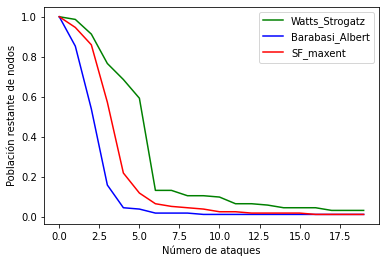

In [ ]:
GA2 = GA.copy()
GB2 = GB.copy()
GW2 = GW.copy()
num_attacks = 20
GW2, ATTACKW,DAMAGEW = hub_cascade_failure(GW2,1,1.1,num_attacks)
GB2, ATTACKB,DAMAGEB = hub_cascade_failure(GB2,1,1.1,num_attacks)
GA2, ATTACK,DAMAGE = hub_cascade_failure(GA2,1,1.1,num_attacks)

print(wDegree_Entropy,BDegree_Entropy,ADegree_Entropy,"degree")
print(wEigenvector_Entropy,BEigenvector_Entropy, AEigenvector_Entropy,"eigen")
print(wBetweenness_Entropy,BBetweenness_Entropy, ABetweenness_Entropy,"betweenness")
print(wCloseness_Entropy,BCloseness_Entropy, ACloseness_Entropy,"closeness")
print(wLoad_entropy,BLoad_entropy, ALoad_entropy,"load")

plt.plot(ATTACKW,DAMAGEW,"green", label ="Watts_Strogatz")
plt.plot(ATTACKB,DAMAGEB,"blue", label = "Barabasi_Albert")
plt.plot(ATTACK,DAMAGE,color ="red", label = "SF_maxent")
plt.xlabel("Número de ataques")
plt.ylabel("Población restante de nodos")
plt.legend(loc = 1)
plt.savefig("hub_cascade_failure.jpg", bbox_inches = "tight", dpi= 300)
for i in range(len(DAMAGEW)):
  sumw = sumw + DAMAGEW[i]
  sumb = sumb + DAMAGEB[i]
  suma = suma + DAMAGE[i]
print(sumw,sumb,suma)

31.702797890110524 65.97214042175666 47.56632799350893


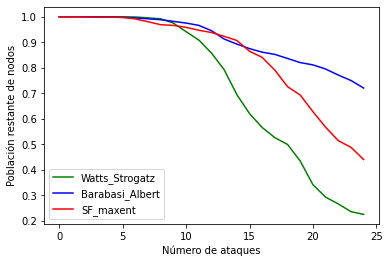

In [ ]:
#ataque aleatorio promedio sobre 60 ataques
muestra = 60
DW = []
DB = []
DA = []
for i in range(muestra):
  GA2 = GA.copy()
  GB2 = GB.copy()
  GW2 = GW.copy()
  num_attacks = 25
  GW2, ATTACKW,DAMAGEW = aleatory_cascade_failure(GW2,1,1.1,num_attacks)
  GB2, ATTACKB,DAMAGEB = aleatory_cascade_failure(GB2,1,1.1,num_attacks)
  GA2, ATTACK,DAMAGE = aleatory_cascade_failure(GA2,1,1.1,num_attacks)
  DW.append(DAMAGEW)
  DB.append(DAMAGEB)
  DA.append(DAMAGE)
DWP = []
DBP = []
DAP = []
for j in range(len(DW[3])):
  sumw = 0
  sumb = 0
  suma = 0
  for i in range(muestra):
    sumw = sumw + DW[i][j]
    sumb = sumb + DB[i][j]
    suma = suma + DA[i][j]
  DWP.append(sumw/muestra)
  DBP.append(sumb/muestra)
  DAP.append(suma/muestra)
plt.plot(ATTACKW,DWP,"green", label ="Watts_Strogatz")
plt.plot(ATTACKB,DBP,"blue", label = "Barabasi_Albert")
plt.plot(ATTACK,DAP,color ="red", label = "SF_maxent")
plt.xlabel("Número de ataques")
plt.ylabel("Población restante de nodos")
plt.legend(loc = 3)
plt.savefig("aleatory_cascade_failureprom.jpg", bbox_inches = "tight", dpi= 300)

for i in range(len(DAMAGEW)):
  sumw = sumw + DWP[i]
  sumb = sumb + DBP[i]
  suma = suma + DAP[i]
print(sumw,sumb,suma)




170.81422222222224 213.04711111111132 198.95955555555574


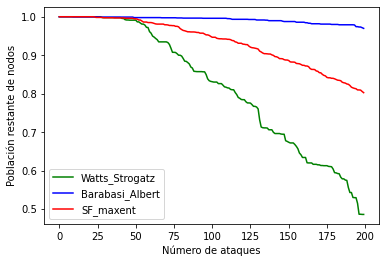

In [ ]:
#ATAQUE ALEATORIO A LOS ENLACES MUESTRA 15
muestra = 15
DW = []
DB = []
DA = []
for i in range(muestra):
  GA2 = GA.copy()
  GB2 = GB.copy()
  GW2 = GW.copy()
  num_attacks = 200
  GW2, ATTACKW,DAMAGEW = edge_aleatory_cascade_failure(GW2,1,1.1,num_attacks)
  GB2, ATTACKB,DAMAGEB = edge_aleatory_cascade_failure(GB2,1,1.1,num_attacks)
  GA2, ATTACK,DAMAGE = edge_aleatory_cascade_failure(GA2,1,1.1,num_attacks)
  DW.append(DAMAGEW)
  DB.append(DAMAGEB)
  DA.append(DAMAGE)
DWP = []
DBP = []
DAP = []
for j in range(len(DW[3])):
  sumw = 0
  sumb = 0
  suma = 0
  for i in range(muestra):
    sumw = sumw + DW[i][j]
    sumb = sumb + DB[i][j]
    suma = suma + DA[i][j]
  DWP.append(sumw/muestra)
  DBP.append(sumb/muestra)
  DAP.append(suma/muestra)

plt.plot(ATTACKW,DWP,"green", label ="Watts_Strogatz")
plt.plot(ATTACKB,DBP,"blue", label = "Barabasi_Albert")
plt.plot(ATTACK,DAP,color ="red", label = "SF_maxent")
plt.xlabel("Número de ataques")
plt.ylabel("Población restante de nodos")
plt.legend(loc = 3)
plt.savefig("edge_aleatory_cascade_failureprom.jpg", bbox_inches = "tight", dpi= 300)
for i in range(len(DAMAGEW)):
  sumw = sumw + DWP[i]
  sumb = sumb + DBP[i]
  suma = suma + DAP[i]
print(sumw,sumb,suma)


5.0022730356420375 4.7361023583260105 4.9076503058898595 degree
4.967697626208014 4.747295929442999 4.769291900331806 eigen
4.688977724944019 3.7783078456004877 4.496642279519523 betweenness
5.006507006476259 5.004381370965698 5.005353919603022 closeness
4.679928169214797 3.8257652467130963 4.515490932388898 load
320.7608888888898 352.03377777777786 348.35955555555586


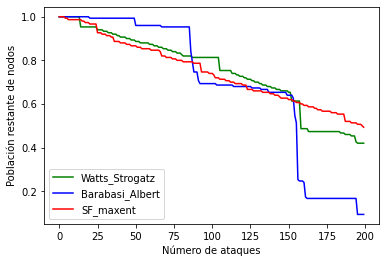

In [ ]:
GA2 = GA.copy()
GB2 = GB.copy()
GW2 = GW.copy()

num_attacks = 200
GW2, ATTACKW,DAMAGEW = edge_hub_cascade_failure(GW2,1,1.1,num_attacks)
GB2, ATTACKB,DAMAGEB = edge_hub_cascade_failure(GB2,1,1.1,num_attacks)
GA2, ATTACK,DAMAGE = edge_hub_cascade_failure(GA2,1,1.1,num_attacks)

print(wDegree_Entropy,BDegree_Entropy,ADegree_Entropy,"degree")
print(wEigenvector_Entropy,BEigenvector_Entropy, AEigenvector_Entropy,"eigen")
print(wBetweenness_Entropy,BBetweenness_Entropy, ABetweenness_Entropy,"betweenness")
print(wCloseness_Entropy,BCloseness_Entropy, ACloseness_Entropy,"closeness")
print(wLoad_entropy,BLoad_entropy, ALoad_entropy,"load")

plt.plot(ATTACKW,DAMAGEW,"green", label ="Watts_Strogatz")
plt.plot(ATTACKB,DAMAGEB,"blue", label = "Barabasi_Albert")
plt.plot(ATTACK,DAMAGE,color ="red", label = "SF_maxent")
plt.xlabel("Número de ataques")
plt.ylabel("Población restante de nodos")
plt.legend(loc = 3)
plt.savefig("edge_hub_cascade_failure.jpg", bbox_inches = "tight", dpi= 300)
for i in range(len(DAMAGEW)):
  sumw = sumw + DAMAGEW[i]
  sumb = sumb + DAMAGEB[i]
  suma = suma + DAMAGE[i]
print(sumw,sumb,suma)

In [ ]:
G = nx.watts_strogatz_graph(100,6,0.1)

sec = Degre_sec_extractor(G)
sec.sort()
results = powerlaw.Fit(sec)
alpha = results.power_law.alpha
print(alpha)
print(sec)

5.002462550700875 4.753017138480231 4.769856854553753 degree
4.925549033114757 4.750823280683746 4.649962810058064 eigen
4.631373646212506 3.8716452511324926 3.9745285877691314 betweenness
5.006445077192678 5.005010475771899 5.002556742437655 closeness
4.624217533214529 3.9123788260166728 4.012284019680983 load


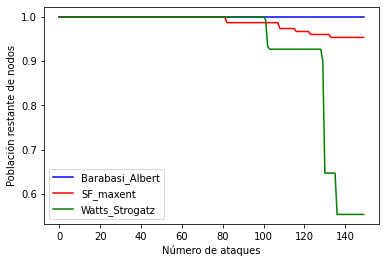

In [ ]:

GA2 = GA.copy()
GB2 = GB.copy()
GW2 = GW.copy()

num_attacks = 150

GW2, ATTACKW,DAMAGEW = edge_aleatory_cascade_failure(GW2,1,1.1,num_attacks)
GB2, ATTACKB,DAMAGEB = edge_aleatory_cascade_failure(GB2,1,1.1,num_attacks)
GA2, ATTACK,DAMAGE = edge_aleatory_cascade_failure(GA2,1,1.1,num_attacks)

print(wDegree_Entropy,BDegree_Entropy,ADegree_Entropy,"degree")
print(wEigenvector_Entropy,BEigenvector_Entropy, AEigenvector_Entropy,"eigen")
print(wBetweenness_Entropy,BBetweenness_Entropy, ABetweenness_Entropy,"betweenness")
print(wCloseness_Entropy,BCloseness_Entropy, ACloseness_Entropy,"closeness")
print(wLoad_entropy,BLoad_entropy, ALoad_entropy,"load")

plt.plot(ATTACKB,DAMAGEB,color ="blue", label = "Barabasi_Albert")
plt.plot(ATTACK,DAMAGE,color ="red", label = "SF_maxent")
plt.plot(ATTACKW,DAMAGEW, color = "green", label = "Watts_Strogatz")
plt.xlabel("Número de ataques")
plt.ylabel("Población restante de nodos")
plt.legend(loc = 3)

plt.savefig("edge_aleatory_cascade_failure.jpg", bbox_inches = "tight", dpi= 300)

for i in range(len(DAMAGEW)):
  sumw = sumw + DAMAGEW[i]
  sumb = sumb + DAMAGEB[i]
  suma = suma + DAMAGE[i]
print(sumw,sumb,suma)

In [ ]:
#Esta función recibe un xfinal hasta donde sumar y un número de particiones.
#Juntos definen la longitud y el valor máximo del vector resultante
def pareto_cumm_probabilities(particiones,xfin, alpha, distribution = st.pareto.cdf):
  """
  (particiones,xfin) -----> (probability_cum_vector)
  Esta función recibe un xfinal hasta donde sumar y un número de particiones.
  Juntos definen la longitud y el valor máximo del vector resultante
  """
  dx = (xfin-1)/particiones
  x = []
  alpha = alpha - 1
  probability_cum_vector = []
  for i in range(particiones):
    equis = 1 + dx*i
    x.append(equis)
    pes = st.pareto.cdf(x[i],alpha) #se eligió un coeficiente de 2.4 para la distribución de pareto
    probability_cum_vector.append(pes)
  return probability_cum_vector, x # entrega como resultado el vector y los valores de x asociados
 
#Este algoritmo es para muestrar secuencias de enteros on una distribución dada. (Montecarlo
def Degree_Sec_Generator(Probabilidad_Acumulada,longitud_Secuencia,m):
  """
  (Vector Probabilidada Acumulada, Longitud Secuencia,m) -------> (Secuencia de enteros con la distribución del vector)
  Este algoritmo es para muestrar secuencias de enteros on una distribución dada. (Montecarlo)
  recuerde que si quiere una secuencia de grado longitud_Secuencia = len(Probabilidad_Acumulada)
  m corresponde al valor mínimo desde el cual se muestreará la distribución, si no es necesario poner 0.
  """
  m = m-1
  Degree_Sequence = []
  sum = 0
  for i in range(longitud_Secuencia):
    k = st.uniform.rvs(scale = Probabilidad_Acumulada[len(Probabilidad_Acumulada)-1]) #Se generan números aleatoriamente entre 0 y 0.9999
    for j in range(len(Probabilidad_Acumulada)): 
      if k <= Probabilidad_Acumulada[j]: # Asocia un entero positivo a cada número entre 0-0.9999
        Degree_Sequence.append(j+m) #construye el vector con los enteros positivos asociados a los números entre 0-1
        break
  return Degree_Sequence


In [ ]:
Nnodes = 150
max_degree = Nnodes -1
pfin = 0.999
m = 3 #grado mínimo para las redes libres de escala
GW = nx.watts_strogatz_graph(Nnodes,6,0.1)
GB = nx.barabasi_albert_graph(Nnodes,m)
secuence = Degre_sec_extractor(GB)
secuence.sort()
results = powerlaw.Fit(secuence,discrete = True)
alpha = results.power_law.alpha
xmin = results.power_law.xmin
print(alpha,"alpha barabasi")


P = [0]
sum = 0
for i in range(1,Nnodes):
  sum = sum + 1/(i**(alpha))
  P.append(1/(i**(alpha)))
sum2 = 0
pc = []
for i in range(len(P)):
  sum2 = sum2 + P[i]/sum
  pc.append(sum2)
  P[i] = P[i]/sum
print(sum2,"sum2")
print(pc)

xfin = st.pareto.isf( 1 - pfin,alpha-1)
xfin = 30
print(xfin,"xfin")
dx = xfin/max_degree 
print(dx,"dx", 1 - pfin)
P, x = pareto_cumm_probabilities(max_degree,xfin,alpha) #creamos el vector de probabilidades acumuladas
 
GA = maxent_generator(P,Nnodes,m)
secuence2 = Degre_sec_extractor(GA)
results2 = powerlaw.Fit(secuence2, discrete = True)
alpha2 = results2.power_law.alpha
xmin2 = results2.power_law.xmin
secuence.sort()
print(len(secuence),secuence)
print(len(secuence2),secuence2)
print(alpha,alpha2,"exponentes")
print(xmin,xmin2,"xmin")
wDegree_Entropy, wEigenvector_Entropy, wBetweenness_Entropy, wCloseness_Entropy, wLoad_entropy = graph_entropys(GW)
BDegree_Entropy, BEigenvector_Entropy, BBetweenness_Entropy, BCloseness_Entropy, BLoad_entropy = graph_entropys(GB)
ADegree_Entropy, AEigenvector_Entropy, ABetweenness_Entropy, ACloseness_Entropy, ALoad_entropy = graph_entropys(GA)
print(GW.number_of_edges(),GB.number_of_edges(),GA.number_of_edges(),"Número de enlaces")
print(wEigenvector_Entropy,BEigenvector_Entropy, AEigenvector_Entropy,"eigen")
print(wBetweenness_Entropy,BBetweenness_Entropy, ABetweenness_Entropy,"betweenness")
print(wLoad_entropy,BLoad_entropy, ALoad_entropy,"load")

Calculating best minimal value for power law fit
/usr/local/lib/python3.7/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/usr/local/lib/python3.7/dist-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


2.5406846346879477 alpha barabasi
1.0000000000000007 sum2
[0.0, 0.7542004460390874, 0.883818202596254, 0.9300852882339116, 0.9523615450342717, 0.9649979761653376, 0.9729494907451641, 0.9783242520253718, 0.9821526751536238, 0.984990969965891, 0.9871626815615282, 0.988867336146993, 0.9902338925929371, 0.9913489777265081, 0.9922726903851649, 0.9930478832988867, 0.99370584050329, 0.9942698729870602, 0.9947576655996819, 0.9951828498406167, 0.9955560826945536, 0.9958858021235719, 0.9961787660222718, 0.9964404431687766, 0.99667530113215, 0.996887021229332, 0.9970786610435788, 0.9972527787198991, 0.997411529040384, 0.9975567384172856, 0.997689963963496, 0.9978125404149796, 0.9979256176972767, 0.9980301912229257, 0.9981271264946503, 0.9982171792135528, 0.9983010118132883, 0.9983792071331495, 0.99845227978608, 0.9985206856583374, 0.9985848298861151, 0.9986450735838827, 0.9987017395443805, 0.9987551170873187, 0.9988054662000793, 0.9988530210869973, 0.9988979932225222, 0.9989405739865336, 0.998980

5.002462550700875 4.753017138480231 4.769856854553753 degree
4.925549033114757 4.750823280683746 4.649962810058064 eigen
4.631373646212506 3.8716452511324926 3.9745285877691314 betweenness
5.006445077192678 5.005010475771899 5.002556742437655 closeness
4.624217533214529 3.9123788260166728 4.012284019680983 load


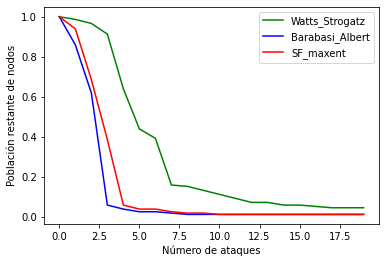

In [ ]:
GA2 = GA.copy()
GB2 = GB.copy()
GW2 = GW.copy()
num_attacks = 20
GW2, ATTACKW,DAMAGEW = hub_cascade_failure(GW2,1,1.1,num_attacks)
GB2, ATTACKB,DAMAGEB = hub_cascade_failure(GB2,1,1.1,num_attacks)
GA2, ATTACK,DAMAGE = hub_cascade_failure(GA2,1,1.1,num_attacks)

print(wDegree_Entropy,BDegree_Entropy,ADegree_Entropy,"degree")
print(wEigenvector_Entropy,BEigenvector_Entropy, AEigenvector_Entropy,"eigen")
print(wBetweenness_Entropy,BBetweenness_Entropy, ABetweenness_Entropy,"betweenness")
print(wCloseness_Entropy,BCloseness_Entropy, ACloseness_Entropy,"closeness")
print(wLoad_entropy,BLoad_entropy, ALoad_entropy,"load")

plt.plot(ATTACKW,DAMAGEW,"green", label ="Watts_Strogatz")
plt.plot(ATTACKB,DAMAGEB,"blue", label = "Barabasi_Albert")
plt.plot(ATTACK,DAMAGE,color ="red", label = "SF_maxent")
plt.xlabel("Número de ataques")
plt.ylabel("Población restante de nodos")
plt.legend(loc = 1)
plt.savefig("hub_cascade_failure2.jpg", bbox_inches = "tight", dpi= 300)

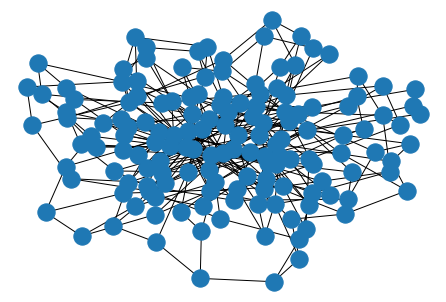

In [ ]:
nx.draw(GA)

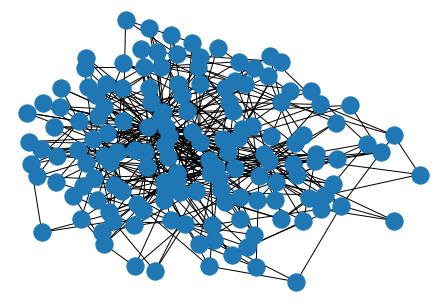

In [ ]:
nx.draw(GB)

In [ ]:
alpha = 2.5
def pareto_int_transform(r,alpha,xmin):
  x = round((xmin -1/2)*(1-r)**(-1/(alpha-1)) + 1/2)
  return x
def pareto_transform(r,alpha,xmin):
  x = xmin*(1-r)**(-1/(alpha - 1))
  return x
dd = 1/100
muestra = []
for i in range(500):
  k = st.uniform.rvs()
  muestra.append(pareto_int_transform(k,2.5,3))
muestra.sort()
print(muestra)
results = powerlaw.Fit(muestra)
alpha = results.power_law.alpha
print(alpha)
print( 100*(2.5-alpha)/alpha)

3.000002000001667
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

Calculating best minimal value for power law fit
/usr/local/lib/python3.7/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [ ]:
P = [0]
sum = 0
for i in range(1,Nnodes):
  sum = sum + 1/(i**(alpha))
  P.append(1/(i**(alpha)))
sum2 = 0
pc = []
for i in range(len(P)):
  sum2 = sum2 + P[i]/sum
  pc.append(sum2)
  P[i] = P[i]/sum
print(sum2)
print(pc)

l = Degree_Sec_Generator(pc,Nnodes,m)
l.sort()
print(l)

1.0000000000000036
[0.0, 0.7797821171771605, 0.902096611903452, 0.9434849812849618, 0.962670899108144, 0.9732389020623051, 0.9797309687267352, 0.9840309771161921, 0.9870404278239077, 0.9892371916151336, 0.9908948597164277, 0.9921797813332363, 0.9931981091921307, 0.9940203267397835, 0.9946948143202107, 0.9952557305046893, 0.9957277847293367, 0.9961292319356602, 0.9964738103085645, 0.9967720293418695, 0.9970320466361461, 0.9972602774863363, 0.9974618267843527, 0.9976408002846313, 0.9978005324133665, 0.997943755352158, 0.9980727261526943, 0.998189323429334, 0.9982951217103946, 0.9983914491842989, 0.9984794329661489, 0.9985600348881933, 0.9986340800255455, 0.9987022796024931, 0.998765249515651, 0.9988235254113939, 0.9988775750345475, 0.9989278084011577, 0.9989745862248253, 0.9990182269326905, 0.999059012535834, 0.9990971935640283, 0.9991329932323035, 0.9991666109736872, 0.9991982254465076, 0.999227997104159, 0.9992560703989599, 0.9992825756787589, 0.9993076308245329, 0.9993313426688316, 0.

5.002462550700875 4.753017138480231 4.769856854553753 degree
4.925549033114757 4.750823280683746 4.649962810058064 eigen
4.631373646212506 3.8716452511324926 3.9745285877691314 betweenness
5.006445077192678 5.005010475771899 5.002556742437655 closeness
4.624217533214529 3.9123788260166728 4.012284019680983 load


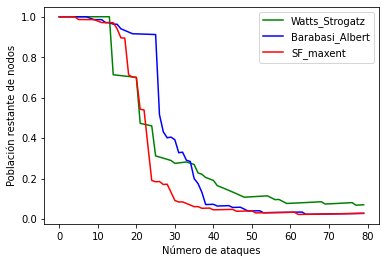

In [ ]:
def hub_attactk(Grafo,numero_ataques):
  DAMAGEEDGE = []
  ATTACK = []
  for i in range(numero_ataques):
    NodosBC = len(max(nx.connected_components(Grafo), key = len))
    DAMAGEEDGE.append(NodosBC/len(Grafo.nodes()))#registramos el daño con el cambio en el tamaño de la componente principal
    ATTACK.append(i) #registramos el numero de ataque
    Grafo = remove_hubs_load(Grafo,1)
  return Grafo, ATTACK, DAMAGEEDGE

GA2 = GA.copy()
GB2 = GB.copy()
GW2 = GW.copy()
num_attacks = 80
GW2, ATTACKW,DAMAGEW = hub_attactk(GW2,num_attacks)
GB2, ATTACKB,DAMAGEB = hub_attactk(GB2,num_attacks)
GA2, ATTACK,DAMAGE = hub_attactk(GA2,num_attacks)

print(wDegree_Entropy,BDegree_Entropy,ADegree_Entropy,"degree")
print(wEigenvector_Entropy,BEigenvector_Entropy, AEigenvector_Entropy,"eigen")
print(wBetweenness_Entropy,BBetweenness_Entropy, ABetweenness_Entropy,"betweenness")
print(wCloseness_Entropy,BCloseness_Entropy, ACloseness_Entropy,"closeness")
print(wLoad_entropy,BLoad_entropy, ALoad_entropy,"load")

plt.plot(ATTACKW,DAMAGEW,"green", label ="Watts_Strogatz")
plt.plot(ATTACKB,DAMAGEB,"blue", label = "Barabasi_Albert")
plt.plot(ATTACK,DAMAGE,color ="red", label = "SF_maxent")
plt.xlabel("Número de ataques")
plt.ylabel("Población restante de nodos")
plt.legend(loc = 1)
plt.savefig("hub_cascade_failure2.jpg", bbox_inches = "tight", dpi= 300)

In [ ]:
nx.utils.po

ImportError: ignored

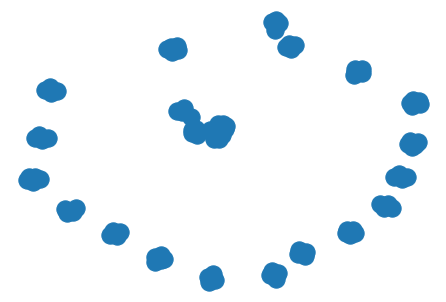

In [ ]:
l = nx.random_powerlaw_tree_sequence(100, gamma = 2.5, seed = None, tries = 5000)
l.sort()
for i in range(len(l)):
  l[i] = l[i] + 2

G = nx.havel_hakimi_graph(l)
nx.draw(G)

In [ ]:
Nnodes = 250
max_degree = Nnodes -1
pfin = 0.999
m = 3 #grado mínimo para las redes libres de escala
P = [0]
sum = 0
for i in range(1,Nnodes):
  sum = sum + 1/(i**(alpha))
  P.append(1/(i**(alpha)))
sum2 = 0
pc = []
for i in range(len(P)):
  sum2 = sum2 + P[i]/sum
  pc.append(sum2)
  P[i] = P[i]/sum
print(sum2,"sum2")


p1 = Degree_Sec_Generator(pc,Nnodes,m)

p1.sort()
print(p1)
print(P)


0.9999999999999998 sum2
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 8, 10, 16]
[0.0, 0.7582616301678674, 0.12849933281251702, 0.04549279607884434, 0.021776228515751863, 0.012297092375163427, 0.007709468224856926, 0.005194910335324286, 0.0036903236615408548, 0.0027293936719614033, 0.0020839352841743627

TypeError: ignored

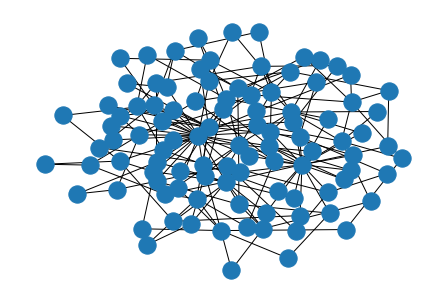

In [ ]:
G = nx.barabasi_albert_graph(100,2)
kamada = nx.kamada_kawai_layout(G)
nx.draw(G,pos = kamada)

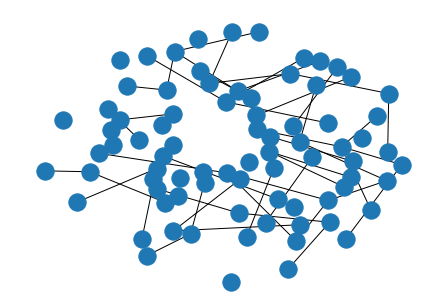

In [ ]:
G = remove_hubs_load(G,20)
nx.draw(G,pos=kamada)

5.00164670850382 4.749722323927245 4.8345212170840295 degree
4.977087808557875 4.747318939446252 4.750289053171971 eigen
4.603216927910213 3.842768653155492 4.18178886806311 betweenness
5.0069822524814285 5.00459892198058 5.004557181006813 closeness
4.595607071826808 3.8964560604767042 4.214844059352887 load


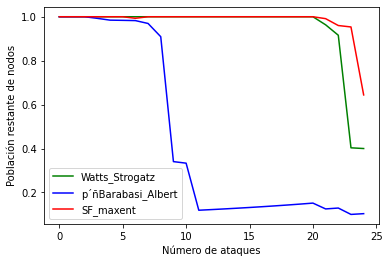

In [ ]:
GA2 = GA.copy()
GB2 = GB.copy()
GW2 = GW.copy()

num_attacks = 25
GW2, ATTACKW,DAMAGEW = aleatory_cascade_failure(GW2,1,1.1,num_attacks)
GB2, ATTACKB,DAMAGEB = aleatory_cascade_failure(GB2,1,1.1,num_attacks)
GA2, ATTACK,DAMAGE = aleatory_cascade_failure(GA2,1,1.1,num_attacks)

print(wDegree_Entropy,BDegree_Entropy,ADegree_Entropy,"degree")
print(wEigenvector_Entropy,BEigenvector_Entropy, AEigenvector_Entropy,"eigen")
print(wBetweenness_Entropy,BBetweenness_Entropy, ABetweenness_Entropy,"betweenness")
print(wCloseness_Entropy,BCloseness_Entropy, ACloseness_Entropy,"closeness")
print(wLoad_entropy,BLoad_entropy, ALoad_entropy,"load")

plt.plot(ATTACKW,DAMAGEW,"green", label ="Watts_Strogatz")
plt.plot(ATTACKB,DAMAGEB,"blue", label = "Barabasi_Albert")
plt.plot(ATTACK,DAMAGE,color ="red", label = "SF_maxent")
plt.xlabel("Número de ataques")
plt.ylabel("Población restante de nodos")
plt.legend(loc = 3)
plt.savefig("aleatory_cascade_failure.jpg", bbox_inches = "tight", dpi= 300)
for i in range(len(DAMAGEW)):
  sumw = sumw + DAMAGEW[i]
  sumb = sumb + DAMAGEB[i]
  suma = suma + DAMAGE[i]
print(sumw,sumb,suma)